In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy.interpolate import LSQUnivariateSpline
%matplotlib notebook

# Problem 1

In [35]:
df = pd.read_csv('data/strongdrink.txt')
df.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [36]:
df.describe()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,1.926136,13.006534,2.327159,2.367386,19.492045,99.840909,2.298920,2.043352,0.359545,1.597727,5.031761,0.961000,2.623409,748.477273
std,0.771047,0.814431,1.117747,0.275617,3.355821,14.329499,0.627333,0.995579,0.123046,0.571958,2.317965,0.227225,0.705369,316.208737
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.597500,2.210000,17.175000,88.000000,1.747500,1.242500,0.267500,1.250000,3.200000,0.790000,1.990000,500.000000
50%,2.000000,13.050000,1.845000,2.360000,19.500000,98.000000,2.380000,2.155000,0.340000,1.560000,4.640000,0.975000,2.780000,673.500000
75%,3.000000,13.682500,3.047500,2.560000,21.500000,107.250000,2.800000,2.882500,0.430000,1.952500,6.147500,1.120000,3.172500,986.250000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


## Problem 1.a

In [37]:
y = df['cultivar']
X = df[['alco', 'malic', 'tot_phen', 'color_int']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)

clf = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

In [38]:
result = {'j = 1': np.append(clf.intercept_[0],clf.coef_[0]),
          'j = 2': np.append(clf.intercept_[1],clf.coef_[1])} 
beta_names = ['intercept', 'alco', 'malic', 'tot_phen', 'color_int']
pd.DataFrame(result, index=beta_names)

,j = 1,j = 2
intercept,-24.027612,22.780728
alco,1.701734,-1.466297
malic,-0.265787,-0.332950
tot_phen,1.224101,0.663556
color_int,0.022508,-0.922682


In [39]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

    accuracy                           0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



- Error rates are: 
    - $j=1$: 0.13
    - $j=2$: 0
    - $j=3$: 0
    
- The model is best at predicting the $j=3$ category, which has highest precision, recall, and f1-socre. 

In [40]:
df.groupby('cultivar').count()

,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
cultivar,,,,,,,,,,,,,
1,59,59,59,59,59,59,59,59,59,59,59,59,59
2,71,71,71,71,71,71,71,71,71,71,71,71,71
3,46,46,46,46,46,46,46,46,46,46,46,46,46


- The second category has the most observations, but the model is best at predicting the third category. 

In [41]:
print('MSE_test = ', mean_squared_error(y_test, y_pred))

MSE_test =  0.045454545454545456


## Problem 1.b

In [42]:
Xvars = X.values
yvars = y.values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)

y_pred = np.zeros(X.shape[0])

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred[test_index] = LogReg.predict(X_test)
    MSE_vec[test_index] = 1 - (y_test == y_pred[test_index])

MSE_loo = MSE_vec.mean()
print('test estimate MSE_loocv =', MSE_loo)

test estimate MSE_loocv = 0.07954545454545454


In [43]:
print(classification_report(yvars, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.93      0.92        59
           2       0.91      0.90      0.91        71
           3       0.96      0.93      0.95        46

    accuracy                           0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



- Error rates are: 
    - $j=1$: 0.10
    - $j=2$: 0.09
    - $j=3$: 0.04
    
The error rates increase in comparison to the results from part 1.a. 

## Problem 1.c

In [44]:
Xvars = X.values
yvars = y.values
k = 4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(k)
y_pred = np.zeros(X.shape[0])

k_ind = 0
for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred[test_index] = LogReg.predict(X_test)
    MSE_vec_kf[k_ind] = (-1 * (y_test == y_pred[test_index]) + 1).mean()
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
print('test estimate MSE_k-fold=', MSE_kf)

test estimate MSE_k-fold= 0.09090909090909091


In [45]:
print(classification_report(yvars, y_pred))

              precision    recall  f1-score   support

           1       0.87      0.93      0.90        59
           2       0.91      0.87      0.89        71
           3       0.96      0.93      0.95        46

    accuracy                           0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



- Error rates are: 
    - $j=1$: 0.13
    - $j=2$: 0.09
    - $j=3$: 0.04
    

The error rates increase in comparison to the results from part 1.a and part 1.b (weakly increase comparing to 1.b). 

# Problem 2

## Problem 2.a

In [46]:
df_cool = pd.read_csv('data/CoolIndex.txt', names=['age', 'coolIndex'])
df_cool.head()

,age,coolIndex
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


<IPython.core.display.Javascript object>


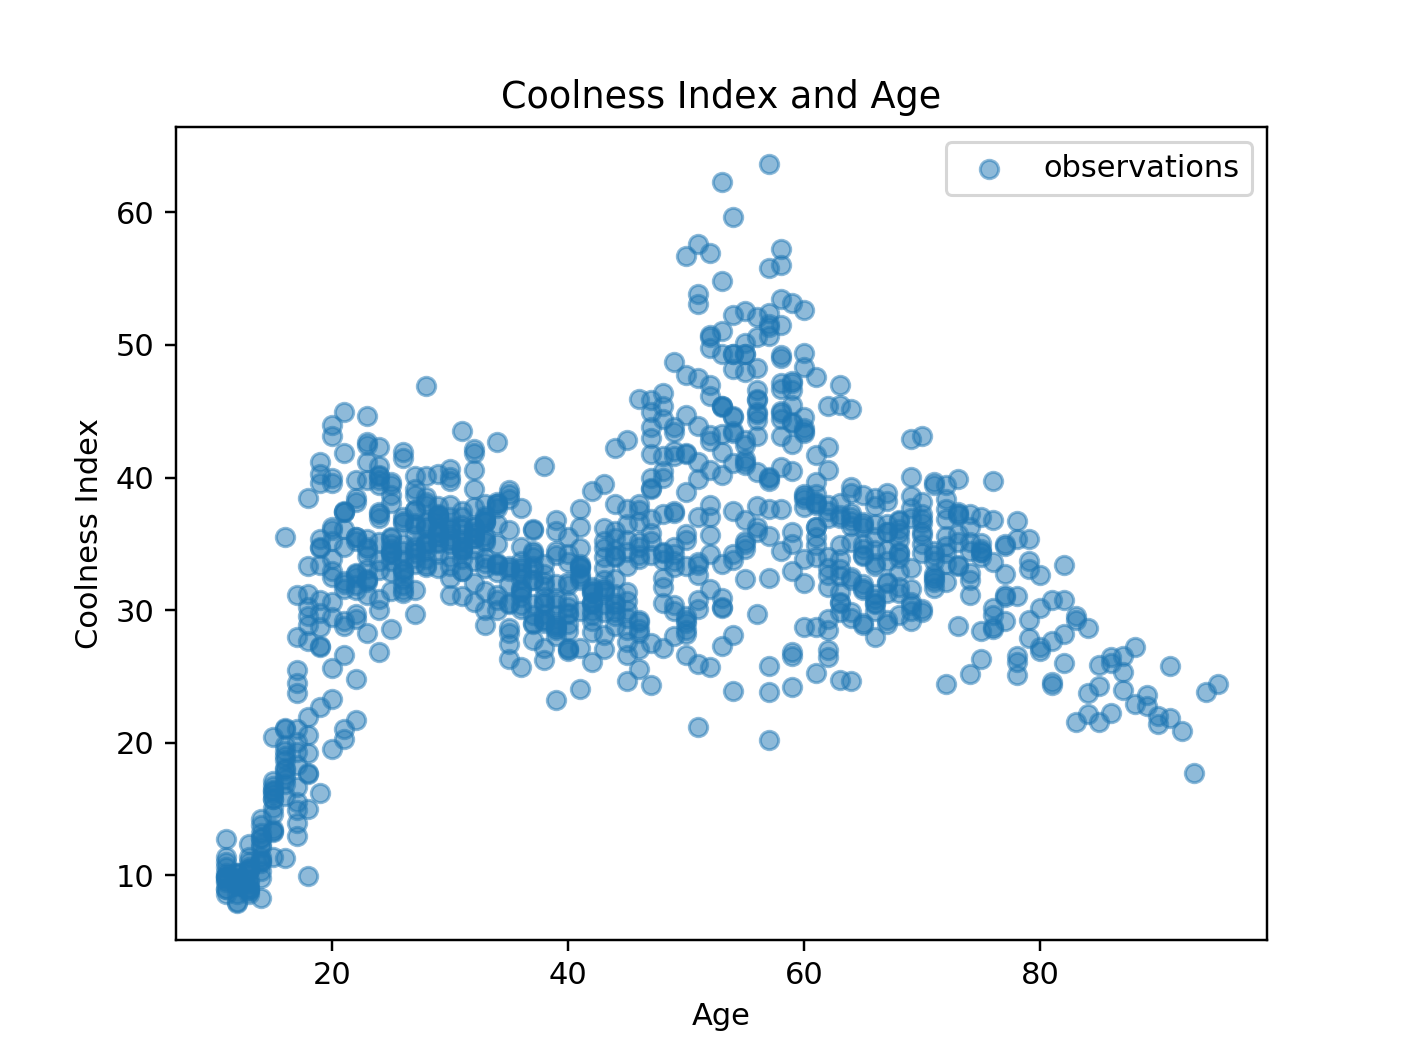

In [47]:
fig, ax = plt.subplots()
ax.scatter(df_cool['age'], df_cool['coolIndex'], alpha=0.5, label='observations')
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.set_title('Coolness Index and Age')
plt.legend()
plt.show()

## Problem 2.b

In [48]:
df_cool['age_11_22'] = np.where((df_cool['age'] >= 11) & (df_cool['age'] < 22), 1, 0)
df_cool['age_22_40'] = np.where((df_cool['age'] >= 22) & (df_cool['age'] < 40), 1, 0)
df_cool['age_40_59'] = np.where((df_cool['age'] >= 40) & (df_cool['age'] < 59), 1, 0)
df_cool['age_59_77'] = np.where((df_cool['age'] >= 59) & (df_cool['age'] < 77), 1, 0)
df_cool['age_77_95'] = np.where((df_cool['age'] >= 77) & (df_cool['age'] <= 95), 1, 0)

In [49]:
# Since the dummies cover all the ages in the sample, there will be no constant term in the regression model. 
X = df_cool[['age_11_22', 'age_22_40', 'age_40_59', 'age_59_77', 'age_77_95']]
y = df_cool['coolIndex']
OLS_result = sm.OLS(y, X).fit()
print(OLS_result.summary())

                            OLS Regression Results                            
Dep. Variable:              coolIndex   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Mon, 24 Feb 2020   Prob (F-statistic):          3.73e-114
Time:                        14:54:17   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_11_22     20.1025      0.562     35.746      0.0

<IPython.core.display.Javascript object>


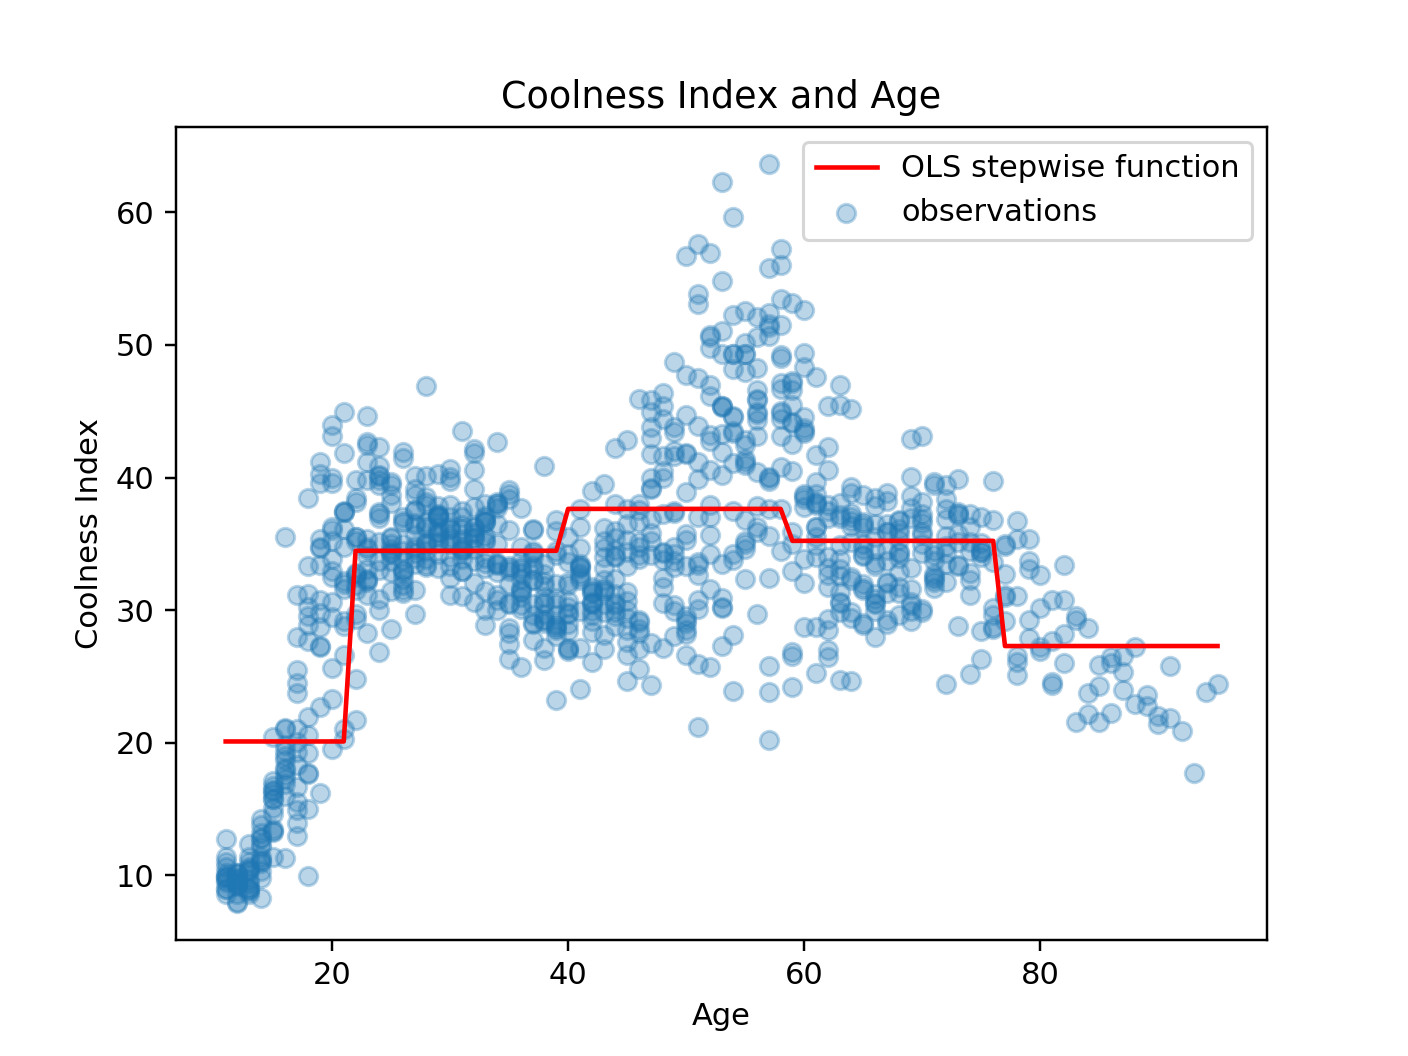

In [50]:
fig, ax = plt.subplots()
ax.scatter(df_cool['age'], df_cool['coolIndex'], alpha=0.3, label='observations')
ax.plot(df_cool['age'], OLS_result.predict(), label='OLS stepwise function', color='red')
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.set_title('Coolness Index and Age')
plt.legend()
plt.show()

In [51]:
# Predict for age=73, i.e. (0, 0, 0, 1, 0)
print(f'Predicted CoolIndex for age=73: {OLS_result.predict([0,0,0,1,0])[0]}')

Predicted CoolIndex for age=73: 35.22540004024275


## Problem 2.c

In [52]:
# Linear spline

df_cool_spline = df_cool[['age', 'coolIndex']].groupby('age').mean()
knots = [22, 40, 59, 77]
linear_spline = LSQUnivariateSpline(df_cool_spline.index, df_cool_spline['coolIndex'], t=knots, k=1)

<IPython.core.display.Javascript object>


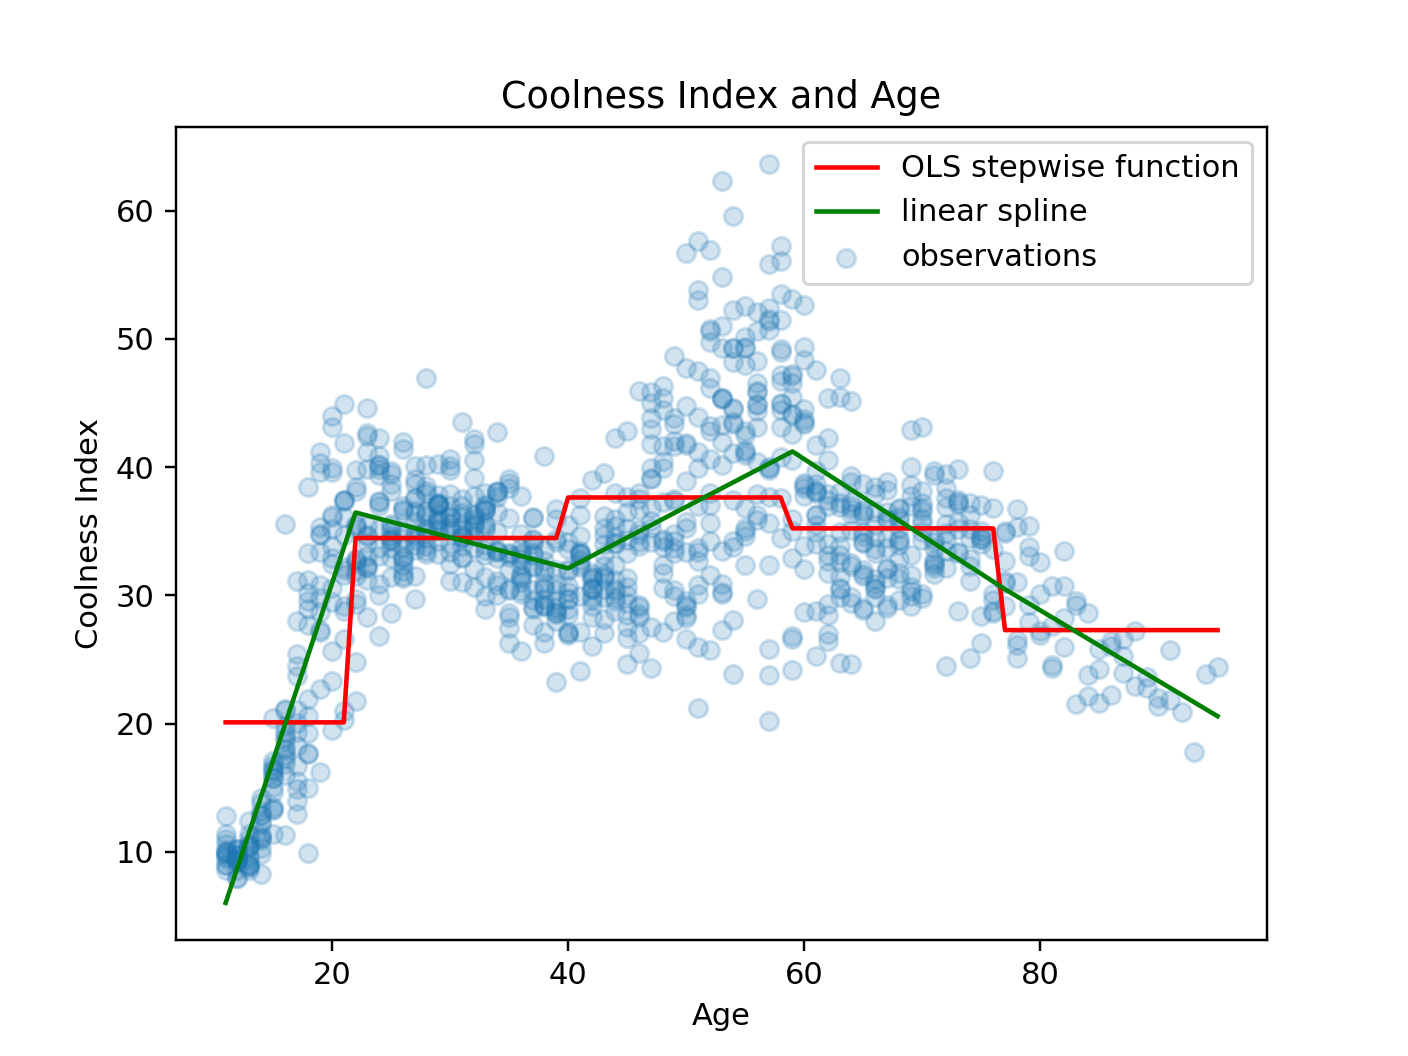

In [53]:
# Plot the spline
fig, ax = plt.subplots()
ax.scatter(df_cool['age'], df_cool['coolIndex'], alpha=0.2, label='observations')
ax.plot(df_cool['age'], OLS_result.predict(), label='OLS stepwise function', color='red')
ax.plot(df_cool_spline.index, linear_spline(df_cool_spline.index), label='linear spline', color='green')
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.set_title('Coolness Index and Age')
plt.legend()
plt.show()

In [54]:
# Predict for age=73
print(f'Predicted CoolIndex for age=73: {linear_spline(73)}')

Predicted CoolIndex for age=73: 32.86784862349653


## Problem 2.d

In [55]:
# cubic spline

df_cool_spline = df_cool[['age', 'coolIndex']].groupby('age').mean()
knots = [22, 40, 59, 77]
cubic_spline = LSQUnivariateSpline(df_cool_spline.index, df_cool_spline['coolIndex'], t=knots, k=3)

<IPython.core.display.Javascript object>


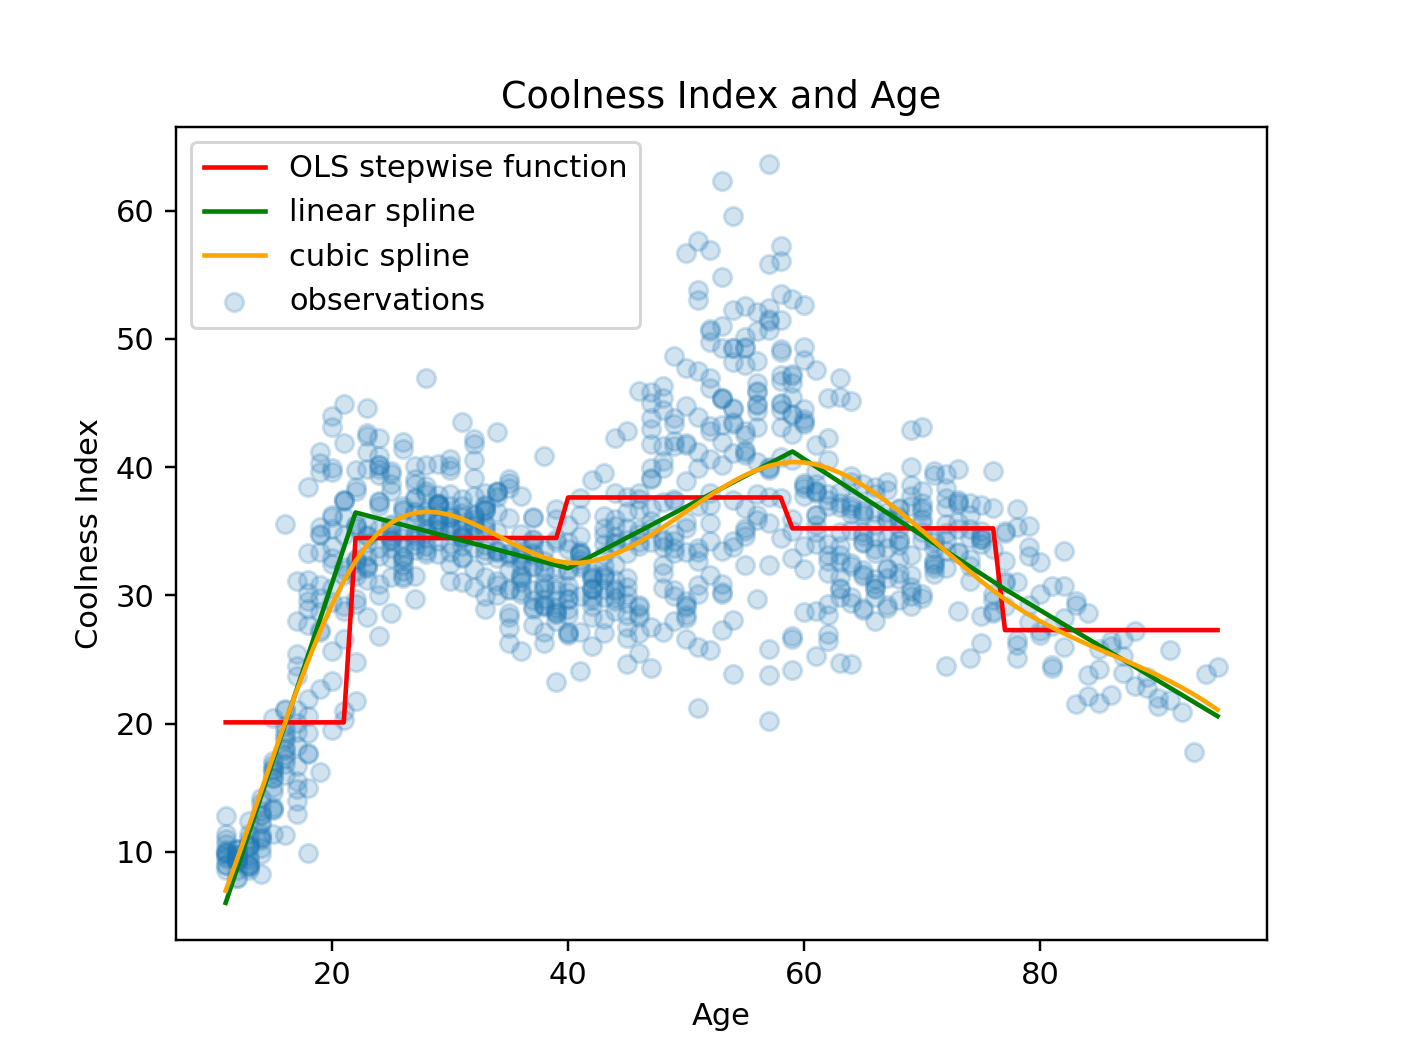

In [56]:
# Plot the spline
fig, ax = plt.subplots()
ax.scatter(df_cool['age'], df_cool['coolIndex'], alpha=0.2, label='observations')
ax.plot(df_cool['age'], OLS_result.predict(), label='OLS stepwise function', color='red')
ax.plot(df_cool_spline.index, linear_spline(df_cool_spline.index), label='linear spline', color='green')
ax.plot(df_cool_spline.index, cubic_spline(df_cool_spline.index), label='cubic spline', color='orange')
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.set_title('Coolness Index and Age')
plt.legend()
plt.show()

In [57]:
# Predict for age=73
print(f'Predicted CoolIndex for age=73: {cubic_spline(73)}')

Predicted CoolIndex for age=73: 32.642301066279764


___

Some useful reference about __spline interpolation__: 

- https://blog.csdn.net/lsxpu/article/details/38849775
- http://aero-comlab.stanford.edu/Papers/splines.pdf